<a href="https://colab.research.google.com/github/paulxshen/Luminescent.jl/blob/master/Luminescent_AI_docs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FDTD Luminescent Simulation and Inverse Design

v0.4.16-beta  
2025/01/24
Paul Shen <pxshen@alumni.stanford.edu>  
Open https://colab.research.google.com/github/paulxshen/Luminescent.jl/blob/master/Luminescent_AI_docs.ipynb if you can't see ouput figures or table of contents.

# Synopsis

[Luminescent AI](https://luminescentai.com/) empowers photonic and RF engineers to simulate or inverse design complex electromagnetic components in just a few lines of code! We created an automatic differentiation (AD) and GPU compatible FDTD engine and geometry generator for photonic integrated circuits (PIC) and metasurfaces, as well (in the future) RF microstrip circuits and patch antennas.

 Experimental release 🥼. Expect bugs 🐛🐞 The commented out cells haven't been updated and tested

[Follow us](https://www.linkedin.com/company/luminescent-ai/about) for updates! Star us [GitHub](https://github.com/paulxshen/Luminescent.jl) if you like our work. We respond to issues within a day  

In [ ]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/n_O1r6wggLU?si=x2tKzw4hzrIz6h7C" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

AI generated mode converter and wavelength domain demultiplexer

# Features and conventions

We do simulation and generative inverse design in 3D or 2.5D, with multiple wavelengths and modes, and on CPU or GPU. However, GPU acceleration is guaranteed only for simulation and not inverse design because the later requires significant VRAM.


## Technical features of FDTD backend
- Automatic differentiation (AD) compatible for adjoint optimization
- Optional GPU acceleration
- Length scale controlled geometry optimizer
- Nonlinear and anisotropic materials
- Tensor subpixel smoothing for accuracy
- Adaptive graded grid and Float16 support for speed
- PML, periodic, PEC, PMC boundaries
- Modal sources, plane waves, Gaussian beams
- Modal monitors, DFT fields

## Geometry layout
We layout using Python  gdsfactory which is integrated with KLayout. Can also import .gds into gdsfactory . Internally, gdsfactory component and layer stack let generate a 3D mesh which is clipped vertically some depths above and below `core_layer`. By default,
we apply a SOI 220nm node (Si, SiO, SiN and Ge layers) implemented by [`gdsfactory.generic_tech`](https://gdsfactory.github.io/gdsfactory/notebooks/03_layer_stack.html#layerstack) layer stack.


## Materials
We're changing to Meep's materials library. We map gdsfactory layerstack layers to Meep materials via the layer's material property while taking into account common name variants (eg "si" or "Si" mapping to "cSi").

Dispersive, anisotropic, and nonlinear materials are by default not simulated but can be implemented upon request.

## Margins and ports
We automatically extend waveguides and adds margins during simulation but port locations remain fixed thus not affecting sparams. Port numbers map to gdsfactory component ports. Specify port pairs as eg `2,1` which is equivalent to `o2@0,o1@0` meaning optical_port_number@mode_number.

## Reciprocity and symmetry
Usually only a subset of sparams is needed because of symmetry or reciprocity, specified as `keys` in sparams study or inferred automatically from inverse design study. We do a run for each port excitation. If `keys` is omitted in sparams study, all sparams will be calculated requiring more runs.

## File workflow
Each simulation or design optimization run is saved to a folder path. Can access saved runs via `load_res`, `finetune`

# Hardware

## Requirements
Simulation (3D 10um x 10um): 16G RAM, NVIDIA GPU (if using GPU)
Inverse design (2.5D 5um x 5um): 32G RAM


## Performance
Setup: Intel Xeon CPU, Nvidia T4 GPU on Google Colab.

### GPU vs CPU
GPU is 30x faster than CPU in simulation!! For inverse design speedup is less than 2x - we're still debugging bottlenecks - it's recommended to use CPU instead because of limited VRAM

### Float32 vs Float16
Float32 is default. We observe small discrepancies when using Float16 so it's best to stick to float32 for high fidelity simulation but OK to use float16 for inverse design to conserve memory by 2x. Computation acceleration is small (1.3x in our setup).

GPUs and some newer CPUs (excluding consumer Intel chips) support Float16 in hardware. Running Float16 on non-supported CPU results in very slow software emulation.

## Non Nvidia GPUs
NVidia GPUs work out of the box. Julia also supports AMD, Intel, and Apple Silicon GPUs but we haven't tested them. Please contact us if you'd like support for these GPUs.

# Known issues

## Silent OOM crashes
Notebook can show successful completion even if the underlying Julia process crashes due to out-of-memory (OOM) errors.

# Installation


We recommend 32G RAM and NVIDIA GPU. If you don't have a GPU, you can still run on CPU but it will be slow.

## Frontend
If on Windows, Install Anaconda distribution of Python and use  Anaconda Prompt for pip installs.  


In [2]:
%%shell
pip install -U luminescent &> /dev/null

## Backend
Install Julia FDTD binaries 

### Linux (Ubuntu 24)
Binaries were compiled on Ubuntu 24 with latest CUDA drivers and may or may not work in other Linux envs. Check output of last cell for errors. If using your own machine, modify your shell profile to permanently add bin to your path!

In [4]:
%%shell
pip install gdown
gdown https://drive.google.com/uc?id=1qBICyiUefU7121aSuOH1B_owdISwLFJ5
# Luminescent.tar.gz
sudo tar xf Luminescent.tar.gz -C /usr/local 

export PATH=$PATH:/usr/local/Luminescent/bin

In [ ]:
# for notebook environments like colab that can't manipulate PATH in shell
import os
os.environ['PATH'] += ':/usr/local/Luminescent/bin'


In [ ]:
!Luminescent

### Windows
Binaries available upon request

## Special instructions for free tier  Google Colab
Update: doesn't run on Colab because of CUDA configuration issues. We're working on a fix. Use your own machine with Ubuntu 24 and latest CUDA drivers.

For simulation, use T4 GPU. For inverse design , use TPU runtime for its better CPU and RAM - we don't actually use the TPU.

# Tutorials: PIC S-parameters simulation

## waveguide bend

### 1um inner radius

#### Single wavelength 3D
We characterize insertion loss (IL) of waveguide bends wrt radius. We first set R=1um, significantly below the often cited minimum radius of 5um in silicon photonics. First, we use `gdsfactory` to make the bend (note `gdsfactory` uses inner radius). Next, we simulates and saves results, which are retrieved and visualized by `load_res`.

`nres` is the maximum resolution - the number of points per wavelength in free space. The grid is adaptive so border regions actually use a lower resolution for speed. Remember FDTD scales as O(n^4)! `nres` has a huge effect on simulation time! Finally, Because of reciprocity we only need S or T param keys of "2,1".


In [ ]:
import luminescent as lumi
import gdsfactory as gf
import numpy as np
import os

radius = 1
c = gf.components.bend_circular(radius=radius,allow_min_radius_violation=True)
# c.plot()

path = os.path.join("runs",f"bend_R{radius}")
wavelengths = 1.55
keys=["2,1"] # same as keys=["o2@0,o1@0"]
nres=30
gpu="CUDA" # or None

lumi.make_pic_sim_prob(path, c, wavelengths=wavelengths, nres=nres, keys=keys, gpu=gpu)
lumi.solve(path)

Write PosixPath('/content/runs/bend_R1.0/temp/clad_999_0.stl') zmin = 0.000, height = 1.298
Write PosixPath('/content/runs/bend_R1.0/temp/box_999_0.stl') zmin = -1.078, height = 2.377
Write PosixPath('/content/runs/bend_R1.0/temp/core_1_0.stl') zmin = 0.000, height = 0.220
/usr/local/lib/python3.10/dist-packages/luminescent/pic
runs/bend_R1.0/problem.json
using simulation folder runs/bend_R1.0
loading problem from /content/runs/bend_R1.0
no fdtd binaries found - starting julia session to compile fdtd code - will take 5mins - let's take a break :) ...
/root/.julia/environments/v1.11/Project.toml

using CUDA backend.
setting up simulation...
σpml = ϵmin * v = 8.294402122497559
mpml = μmin * v = 4.0
pml_depths = trim.(pml_depths, maxdeltas) = Float32[0.8000001, 0.8000001, 0.13333334]
saving mode solutions
saving mode solutions
(Ttrans, Tss) = (22.735996151052376, 10)
using GPU backend.
compiling simulation code...
preprocessing geometry...
propagating transient fields...
simulation period

loading solution from /content/runs/bend_R1.0


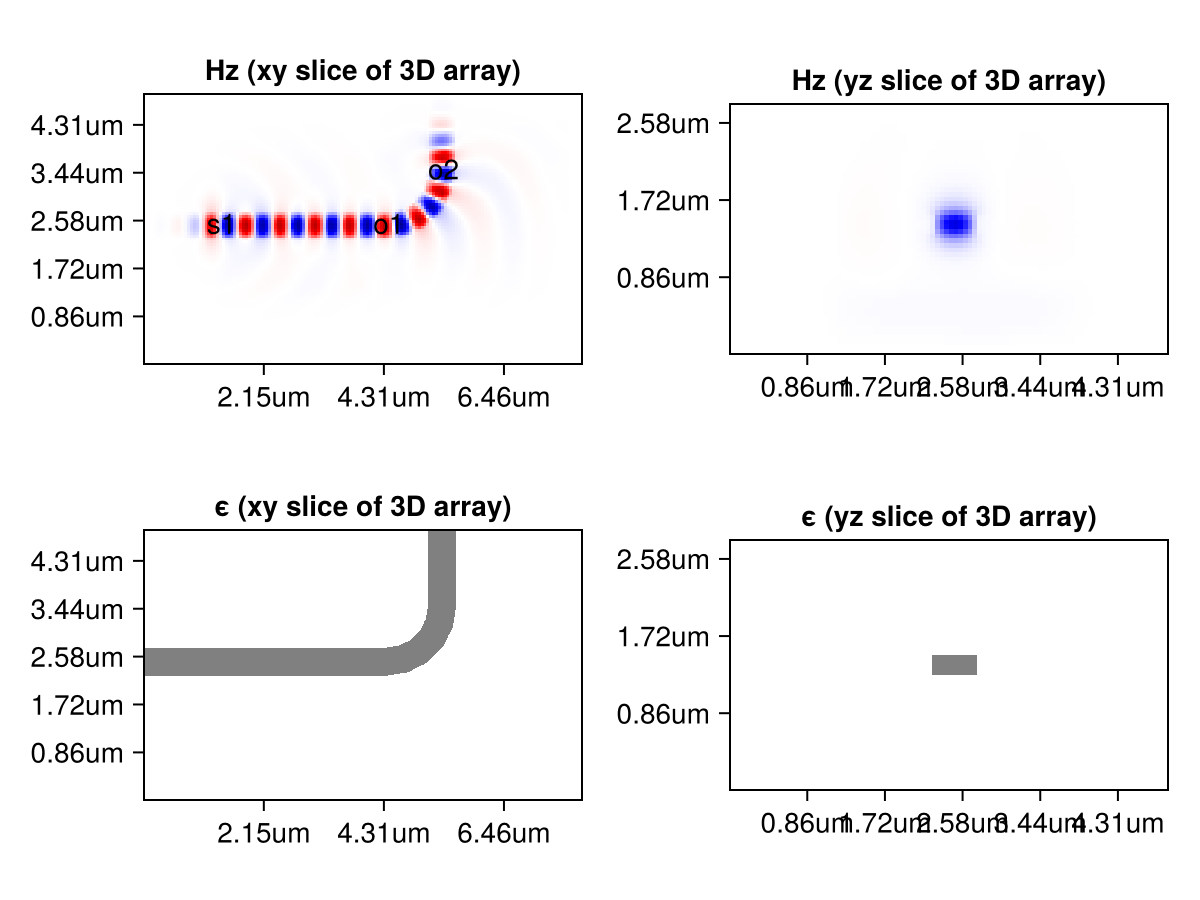

{'S': {'1.55': {'o1@0,o1@0': (0.04141667-0.019173963j),
                'o2@0,o1@0': (-0.91204363+0.30843103j)}},
 'T': {'1.55': {'o1@0,o1@0': 0.0020829816, 'o2@0,o1@0': 0.9269533}},
 'dB': {'1.55': {'o1@0,o1@0': -26.813145, 'o2@0,o1@0': -0.3294214}},
 'optimized_designs': '[[...]]',
 'path': '/content/runs/bend_R1.0',
 'phasors': {'1.55': {'o1@0,o1@0': {'mag': 0.045639694, 'phase': -24.841908},
                      'o2@0,o1@0': {'mag': 0.9627841, 'phase': 161.3157}}}}


In [ ]:
path = os.path.join("runs",f"bend_R1")
sol = lumi.load_res(path)


Loss at 0.3dB

#### Wavelength range 3D
We can repeat the simulation with multiple wavelengths in a range. Closely spaced wavelengths may require longer integration periods to resolve.


In [ ]:
path = os.path.join("runs",f"bend_R{radius}_multi")
wavelengths = np.linspace(1.5, 1.6, 5)  # number or list or array

lumi.make_pic_sim_prob(path,c,  wavelengths=wavelengths, nres=nres, keys=keys, gpu=gpu)
lumi.solve(path)

wavelengths has been adjusted to facilitate simulation:
[1.5037313432835824, 1.5265151515151516, 1.55, 1.57421875, 1.5992063492063493]
Write PosixPath('/content/runs/bend_R1.0_multi/temp/clad_999_0.stl') zmin = 0.000, height = 1.298
Write PosixPath('/content/runs/bend_R1.0_multi/temp/box_999_0.stl') zmin = -1.078, height = 2.377
Write PosixPath('/content/runs/bend_R1.0_multi/temp/core_1_0.stl') zmin = 0.000, height = 0.220
/usr/local/lib/python3.10/dist-packages/luminescent/pic
runs/bend_R1.0_multi/problem.json
using simulation folder runs/bend_R1.0_multi
loading problem from /content/runs/bend_R1.0_multi
no fdtd binaries found - starting julia session to compile fdtd code - will take 5mins - let's take a break :) ...
/root/.julia/environments/v1.11/Project.toml

using CUDA backend.
setting up simulation...
σpml = ϵmin * v = 8.294402122497559
mpml = μmin * v = 4.0
pml_depths = trim.(pml_depths, maxdeltas) = Float32[0.8000001, 0.8000001, 0.13333334]
saving mode solutions
saving mode sol

loading solution from /content/runs/bend_R1.0_multi


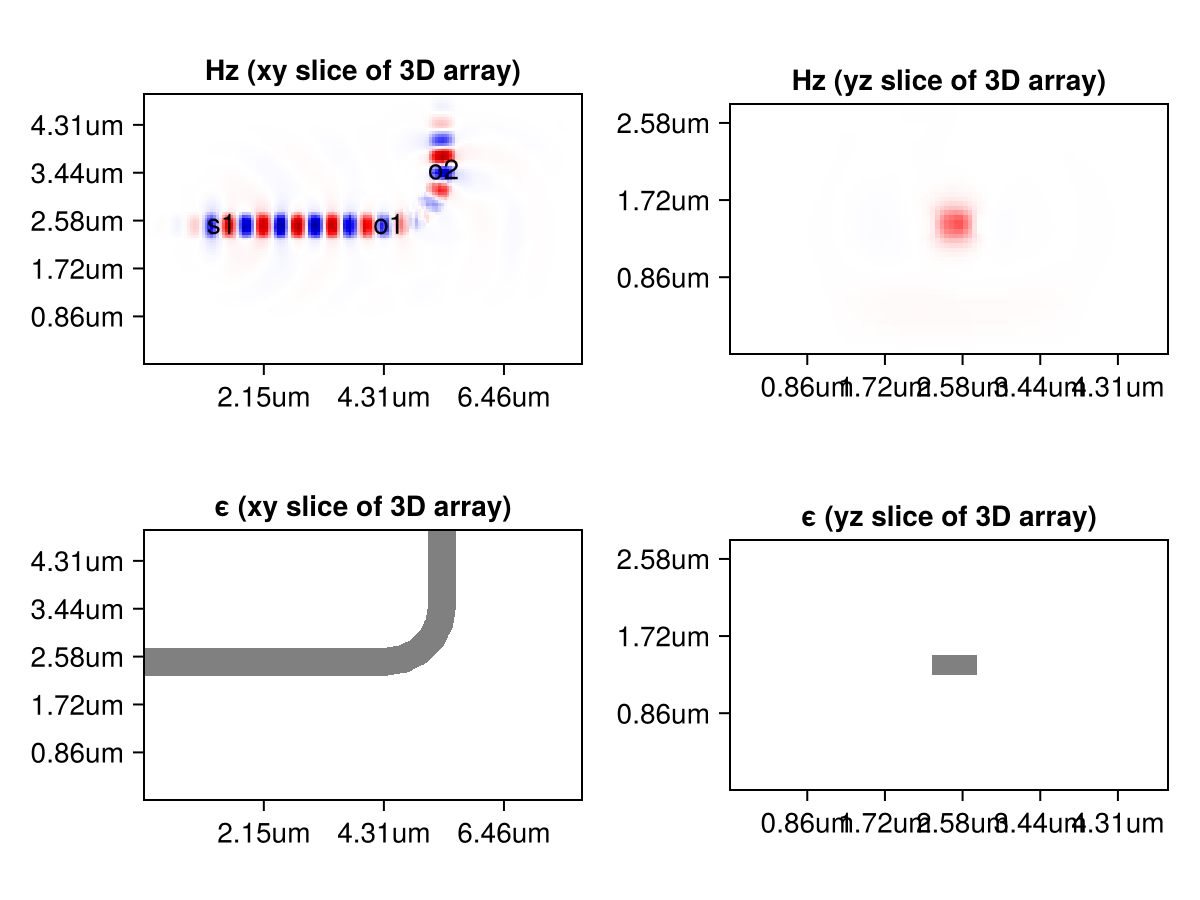

{'S': {'1.5037313432835824': {'o1@0,o1@0': (0.03238864-0.049399078j),
                              'o2@0,o1@0': (-0.39100677+0.8927385j)},
       '1.5265151515151516': {'o1@0,o1@0': (0.0427214-0.037471976j),
                              'o2@0,o1@0': (-0.7146585+0.654358j)},
       '1.55': {'o1@0,o1@0': (0.041602407-0.019109435j),
                'o2@0,o1@0': (-0.91218054+0.30871493j)},
       '1.57421875': {'o1@0,o1@0': (0.026987294-0.0051358407j),
                      'o2@0,o1@0': (-0.9542684-0.08467782j)},
       '1.5992063492063493': {'o1@0,o1@0': (0.0060112355-0.0048308275j),
                              'o2@0,o1@0': (-0.8351782-0.46081996j)}},
 'T': {'1.5037313432835824': {'o1@0,o1@0': 0.0034892927,
                              'o2@0,o1@0': 0.9498683},
       '1.5265151515151516': {'o1@0,o1@0': 0.003229267, 'o2@0,o1@0': 0.9389212},
       '1.55': {'o1@0,o1@0': 0.0020959307, 'o2@0,o1@0': 0.92737824},
       '1.57421875': {'o1@0,o1@0': 0.0007546909, 'o2@0,o1@0': 0.9177985},
   

In [ ]:
path = os.path.join("runs",f"bend_R1_multi")
sol = lumi.load_res(path)

Longer wavelengths are lossier as expected. Undulating spatial intensity is due to interference between multiple wavelengths.

#### Quickie 2.5D approximation
Set `approx_2D_mode="TE"` to do a 2.5D simulation using (Ex, Ey, Hz) on a 2D plane with an "effective" refractive index integrated from a vertical modal profile. This is significantly faster but not accurate. Nevertheless it's a good way of exploring various geometries.

### 5um inner radius
Let's try a normal R=5um bend.

In [ ]:
import luminescent as lumi
import gdsfactory as gf
import os

radius = 5
c = gf.components.bend_circular(radius=radius,allow_min_radius_violation=True)
# c.plot()

path = os.path.join("runs",f"bend_R{radius}")
wavelengths = 1.55
keys=["2,1"] # same as keys=["o2@0,o1@0"]
nres=40
gpu="CUDA" # or None

path = os.path.join("runs",f"bend_R{radius}")
c = gf.components.bend_circular(radius=radius, allow_min_radius_violation=True)
wavelengths = 1.55

lumi.make_pic_sim_prob(path,c,  wavelengths=wavelengths, nres=nres, keys=keys,gpu=gpu)
lumi.solve(path)

loading solution from /content/runs/bend_R5


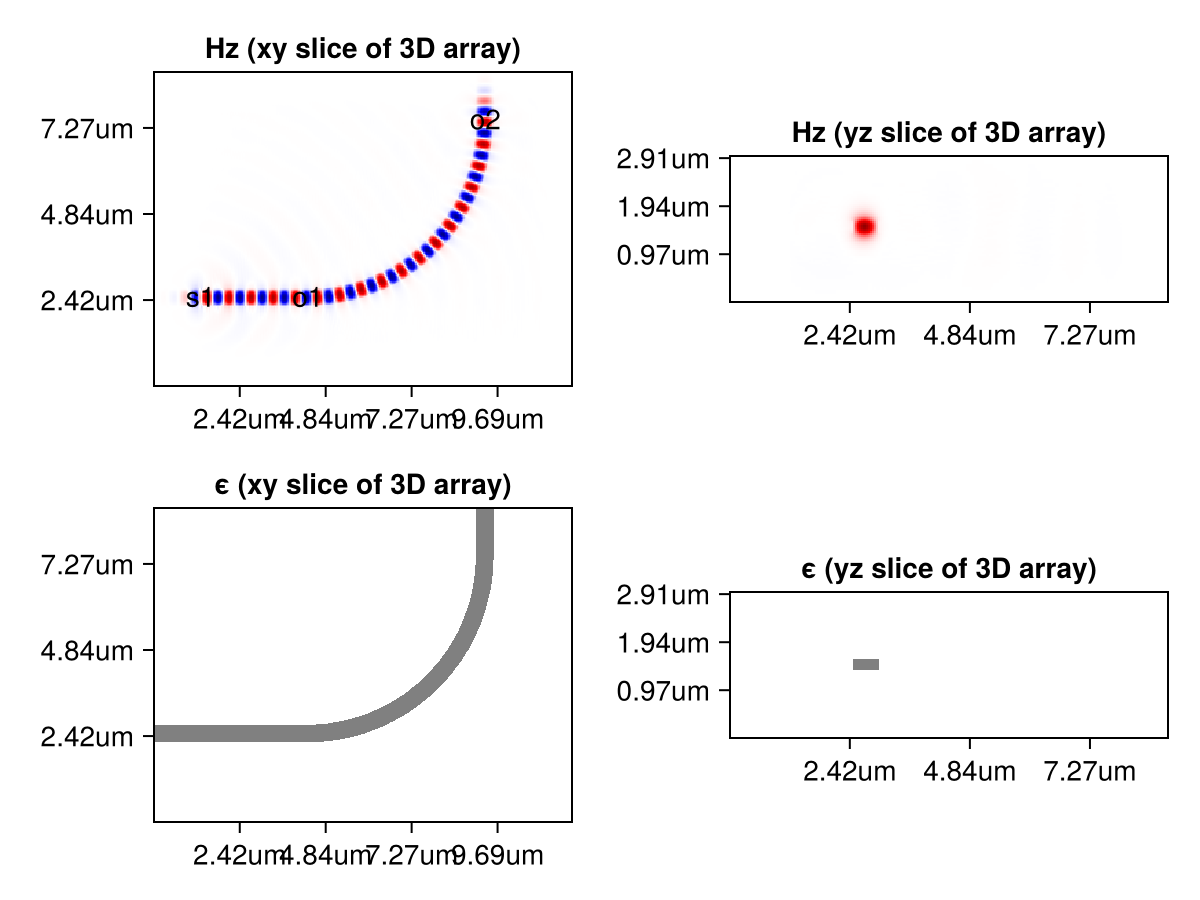

{'S': {'1.55': {'o1@0,o1@0': (0.0037329316-0.01701807j),
                'o2@0,o1@0': (-0.8596787+0.5040148j)}},
 'T': {'1.55': {'o1@0,o1@0': 0.0003035495, 'o2@0,o1@0': 0.99307835}},
 'dB': {'1.55': {'o1@0,o1@0': -35.177704, 'o2@0,o1@0': -0.030164856}},
 'optimized_designs': '[[...]]',
 'path': '/content/runs/bend_R5',
 'phasors': {'1.55': {'o1@0,o1@0': {'mag': 0.017422672, 'phase': -77.628044},
                      'o2@0,o1@0': {'mag': 0.99653316, 'phase': 149.61763}}}}


In [ ]:
path = os.path.join("runs",f"bend_R5")
sol = lumi.load_res(path)


Loss is 0.03dB, similar to [Tidy3D example](https://www.flexcompute.com/tidy3d/examples/notebooks/EulerWaveguideBend/)

## customizing materials, layers, and modes

#### Defaults

In [ ]:
# import luminescent as lumi
# from gdsfactory.generic_tech import LAYER,LAYER_STACK
# import gdsfactory as gf
# import pprint as pp

# core_layer=LAYER.WG
# bbox_layer=LAYER.WAFER
# layer_stack=LAYER_STACK

# N=3
# dtype="float32"
# gpu=None

#### TE1

In [ ]:
# c = gf.components.straight(length=1.0,width=0.5,layer=core_layer)
# wavelengths=1.55
# nres=30

# path="TE1"
# keys=["o2@1,o1@1"]
# lumi.make_pic_sim_prob(path,c, wavelengths=wavelengths, keys=keys,nres=nres, dtype=dtype, gpu=gpu)
# lumi.solve(path)
# lumi.load_res(path)

### Si rib waveguide
only need to modify bbox_layer to include 90nm bottom silicon slab

In [ ]:
# path="rib"
# keys=["2,1"]
# bbox_layer=[LAYER.WAFER,LAYER.SLAB90]
# lumi.make_pic_sim_prob(path,c, wavelengths=wavelengths, keys=keys,nres=nres,  dtype=dtype, gpu=gpu,
#                    bbox_layer=bbox_layer)
# lumi.solve(path)
# sol = lumi.load_res(path)

### SiN strip waveguide

In [ ]:
# path="SiN"
# core_layer=LAYER.WGN
# c = gf.components.straight(length=2.0, width=1.0, layer=core_layer)

# lumi.make_pic_sim_prob(path,c, wavelengths=wavelengths, keys=keys,nres=nres, dtype=dtype, gpu=gpu,
#                       core_layer=core_layer)
# lumi.solve(path)
# sol = lumi.load_res(path)

# Tutorials: PIC generative inverse design
We introduce GCells (generative cells), a natural evolution of PCells (parametric cells) in semiconductor design . Given a set of inverse design objectives, a GCell will generate optimal geometry using adjoint optimization while ensuring manufacturability by enforcing minimum feature lengths.

In examples below, `mimo` (multi in multi out) is just a gdsfactory component with configurable waveguide ports, simple slab as pre-optimization geometry, and overlying rectangular design regions. Dimensions `l` along x and `w` along y. Ports are numbered incrementally: west (SW->NW) -> east (SE->NE) -> south (SW->SE) -> north (NW->NE). By default, they're spaced equally on a side. Example: `west=1, east=2` places port 1 on west, ports 2 & 3 on east. But can also individually specify their locations and widths. Example : `west=[1.0, 2.5], wwg_west=[0.5, 0.4]`.

Optimization `targets` is a dictionary organized wrt target type & wavelength. Types include T-params (`tparams`, most common), phase difference (`phasediff`), S-params (`sparams`). Multiple types & wavelengths are possible & often necessary . Loss for each type is scaled automatically to vary from 0 to 1 usually . For example , `tparams` loss of 0.5 roughly means 50% of power going to wrong places.

`lvoid` is minimum length scale for voids. No void features smaller than it (currently this isn't exact - contact us for a more precise algorithm). Similarly for `lsolid`.

Setting `approx_2D_mode="TE"` (or "TM") optimizes in 2.5D which serves as a fast initialization for 3D optimization. Examples done at low resolution and lax convergence in 2.5D on CPU. For accuracy, the result must be finetuned in 3D at finer resolution, a feature that can be requested from Luminescent AI .


## Generative cells PDK for passive devices


### wavelength domain demultiplexer

We inverse design a 1x2 wavelength demultiplexer separating different wavelength signals. All we need to do is specify the wavelength dependent Tparams targets.

In [8]:
# 60G RAM
import os
import luminescent as lumi

path = os.path.join("runs", "demux")
c = lumi.mimo(west=1, east=2, l=5.0, w=3.0, wwg=.5, taper=0.05)
targets = {"tparams": {
    1.2: {"3,1": 1.0},
    1.8: {"2,1": 1.0},
}}

lumi.make_pic_inv_prob(
    path, c, targets,
    lvoid=0.15, lsolid=0.1, nres=30,
    approx_2D_mode="TE", stoploss=.1, iters=200, dtype="float16")#,gpu="CUDA")
lumi.solve(path)


{'tparams': {1.2: {'3,1': 1.0}, 1.8: {'2,1': 1.0}}}
['o2@0,o1@0', 'o3@0,o1@0']
wavelengths has been adjusted within `wl_res` to facilitate simulation:
[1.2, 1.7999999999999998]
Write PosixPath('/content/runs/demux/temp/clad_999_0.stl') zmin = 0.000, height = 1.260
Write PosixPath('/content/runs/demux/temp/box_999_0.stl') zmin = -1.040, height = 2.300
Write PosixPath('/content/runs/demux/temp/core_1_0.stl') zmin = 0.000, height = 0.220
/usr/local/lib/python3.10/dist-packages/luminescent/pic
runs/demux/problem.json
using simulation folder runs/demux
runs/demux/problem.json
using simulation folder runs/demux
loading problem from /content/runs/demux
/root/.julia/environments/v1.11/Project.toml

no fdtd binaries found - starting julia session to compile fdtd code - will take 5 mins - can take a break and come back :) ...
setting up simulation...
Float16 selected. make sure your cpu or GPU supports it. otherwise will be emulated and very slow.
using Float16
λ = wl = 1.5
saving mode solutions

Lets see simulation fields and optimized geometry. Note the lax convergence criteria (`stoploss=.1`) means the solution isn't perfect.

loading solution from /content/runs/demux
loading optimized design regions at resolution 0.0125


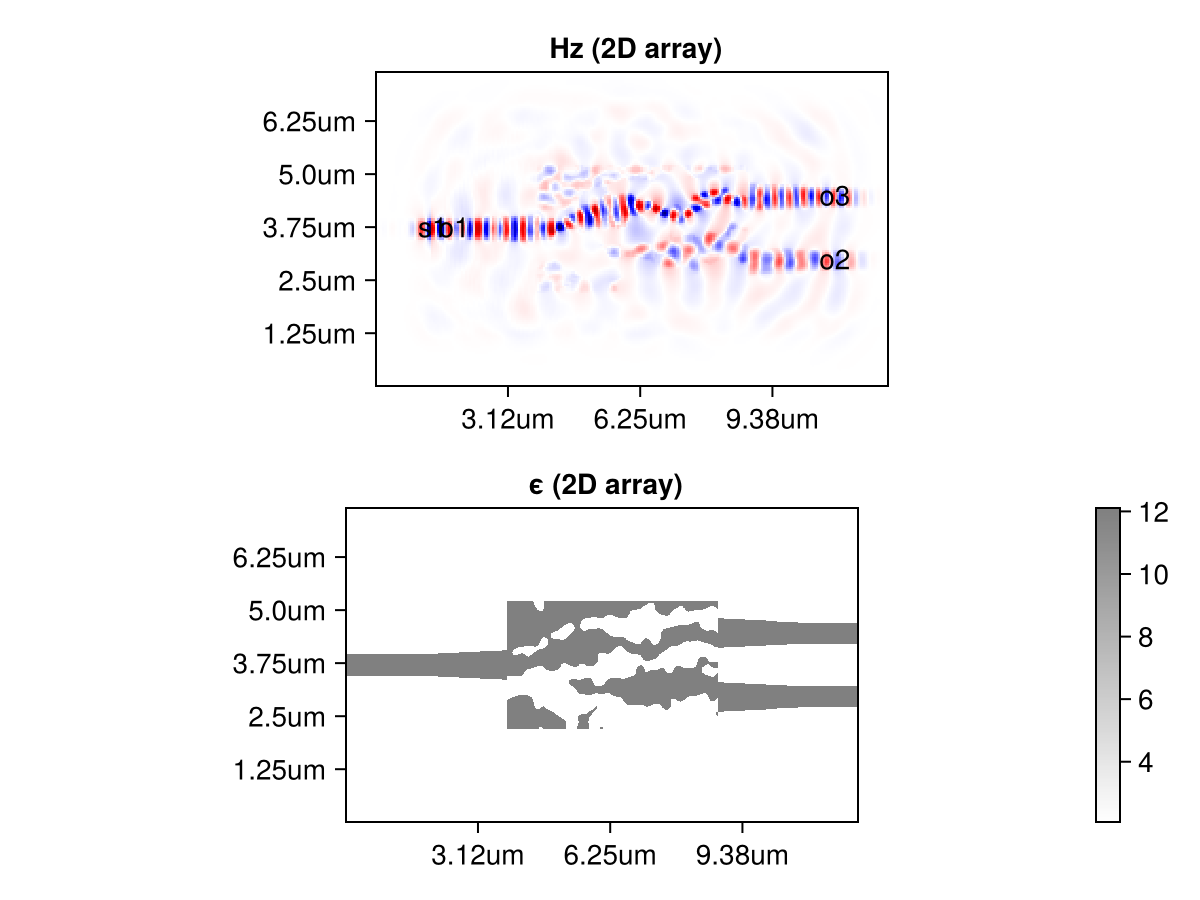

In [9]:
path = os.path.join("runs", "demux")
sol = lumi.load_res(path)

Can optionally optimize more using `finetune`

In [ ]:
# lumi.finetune(path,stoploss=.03,iters=40)

### 1x2 splitter MMI
1.55um wavelength 1x2 splitter. We set symmetry about y so only need to specify T21=.5 as optimization target. Data saved to `path` folder inside working directory. We start iteratiions of adjoint optimization.

In [ ]:
import os
import luminescent as lumi

path = os.path.join("runs","splitter")
c = lumi.mimo(west=1, east=2, l=4.0, w=2.0, wwg=.5, taper=.05, )
targets = {
    "tparams": {1.55: {"2,1": 0.5}},
}

lumi.make_pic_inv_prob(
    path,c, targets,
     nres=20,  symmetries=[1],
    lvoid=0.2, lsolid=.1,
    iters=50, stoploss=.05,
    approx_2D_mode="TE",dtype="float16")#),gpu="CUDA")
lumi.solve(path)

loading solution from c:\Users\pxshe\OneDrive\Desktop\beans\Luminescent.jl\runs\splitter
loading optimized design regions at resolution 0.025833333333333333


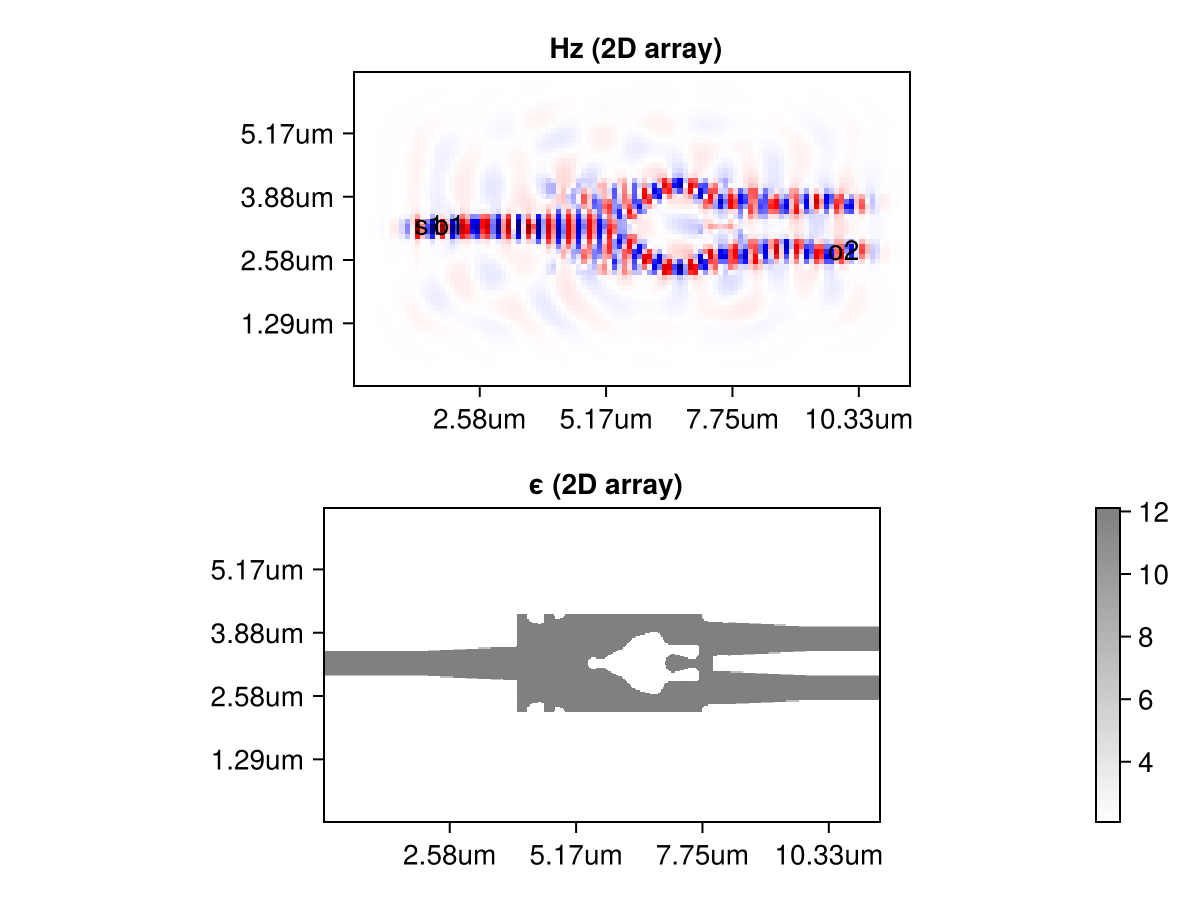

{'S': {'1.55': {'o1@0,o1@0': (-0.012994642-0.21165417j),
                'o2@0,o1@0': (-0.2520984+0.64579886j)}},
 'T': {'1.55': {'o1@0,o1@0': 0.044966348, 'o2@0,o1@0': 0.48060977}},
 'dB': {'1.55': {'o1@0,o1@0': -13.471125, 'o2@0,o1@0': -3.182074}},
 'optimized_designs': '[[...]]',
 'path': 'runs\\splitter',
 'phasors': {'1.55': {'o1@0,o1@0': {'mag': 0.2120527, 'phase': -93.5133},
                      'o2@0,o1@0': {'mag': 0.69326025, 'phase': 111.32401}}}}


In [ ]:
path = os.path.join("runs","splitter")
sol = lumi.load_res(path)

### 1x4 splitter MMI
1x4 splitter at 1.55um with same phase on outputs. Because of symmetry, only need 0.0 phase difference between first 2 outputs.

In [ ]:
# sol = lumi.load_res(path)

### mode converter
We target "o2@1,o1@0", converting optical port 1 mode TE0 input to optical port 2 mode TE1 ouput at 1.55um. Mode converters are notoriously hard to design, but generative AI does it in a pinch!

In [ ]:
# sol = lumi.load_res(path)

### symmetric crossing

In [ ]:
# from pprint import pprint
# import luminescent as lumi

# path=os.path.join("runs", "crossing")
# c = lumi.mimo(west=1, east=1, south=1, north=1, l=4.0, w=4.0, wwg=.5)
# targets = {"tparams":{1.55: {"2,1": 1.0}}}

# lumi.make_pic_inv_prob(
#     path,c, targets,
#     lvoid=0.15,lsolid=0.15, symmetries=[0,1],
#    approx_2D_mode="TE",  nres=30,
# stoploss=.05,iters=100)
# lumi.solve(path)
# sol = lumi.load_res(path)

## GCells PDK for active  devices

### Thermo-optic phase shifters
Please request

## GCells PDK for nonlinear devices
Please request

# Collaboration and research opportunities
We can publish or keep it proprietary, depending on your needs.

Algorithms  
- Reduced basis geometry generators for length scale controlled topology optimization
- Automatic differentiation and GPU compatible FDTD for inverse design in photonics and RF
- Algorithms for reduced memory usage in time domain adjoint optimization
- Neural surrogates for FDTD
  
Photonic applications  
- Energy efficient and compact photonic phase shifters and resonators
- Energy efficient and compact photonic modulators and MZIs
- Inverse design of nonlinear photonic devices
- Inverse design of ...


# Links
[GitHub](https://github.com/paulxshen/Luminescent.jl): Star us :) We respond to issues within a day  
[LinkedIn](https://www.linkedin.com/company/luminescent-ai/about): Follow us for new features and bug fixes  
[Company](luminescentai.com): Consulting, collaboration, publication opportunities available
Email: pxshen@alumni.stanford.edu info@luminescentai.com  
WhatsApp: 650-776-7724  
WeChat: pxshen1230
<!-- [Youtube](https://www.youtube.com/playlist?list=PLaK09N11V08geHeqyLJLDAW0tiDeJtnd4): Video tutorials   -->